1銘柄のみで組んでみる．<br>
状態としては，value, growthのみを利用

In [1]:
import pandas as pd

df_oracle = pd.read_csv('./data_4toy/oracle.csv',index_col=0).iloc[:,0:1]
df_value = pd.read_csv('./data_4toy/val_q.csv',index_col=0).iloc[:,0:1]
df_growth = pd.read_csv('./data_4toy/growth_q.csv',index_col=0).iloc[:,0:1]

In [2]:
df_oracle.head()

,JPNBCG1
date,
20140203,-1.0
20140204,-1.0
20140205,-1.0
20140206,-1.0
20140207,-1.0


ここから逆強化学習

In [3]:
import state
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from policy import eps_greedy

%matplotlib inline 

In [4]:
#df_oracle.iloc[:,0].plot()

In [5]:
def encoding(oracle, value, growth):
    days = oracle.shape[0]
    num_ind = oracle.shape[1]
    feature = np.zeros((num_ind,5,5))
    for i in range(0,num_ind):
        for j in range(0,days):
            #print(i,j)
            q_val = value.iloc[j,i] - 1
            q_growth = growth.iloc[j,i] - 1
            #print(q_val,q_growth)
            feature[i][q_val][q_growth] +=  oracle.iloc[j,i]
    return feature/days

In [6]:
feature = encoding(df_oracle,df_value,df_growth)
print(feature.shape)
feature

(1, 5, 5)


array([[[ 0.02570481,  0.02819237,  0.12023217,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        , -0.00829187,  0.013267  ,  0.        ,
          0.        ]]])

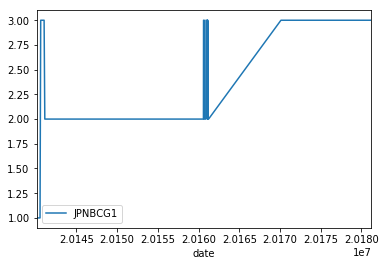

In [7]:
df_growth.plot()

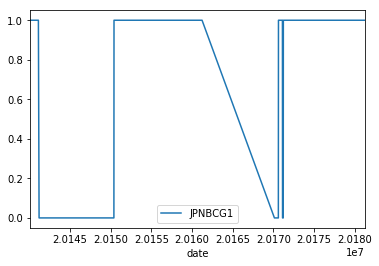

In [8]:
df_value.plot()

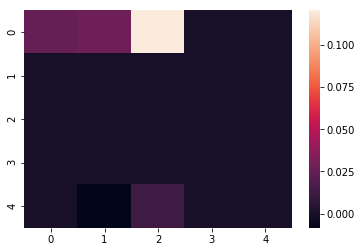

In [9]:
sns.heatmap(feature[0])

In [10]:
def mk_chunk(df, div=10,seed = 0):
    import random
    l = list(df.index)
    random.seed(seed)
    random.shuffle(l)
    tmp = np.array_split(l,div)
    chunk = []
    for i in range(0,div):
        chunk.append(list(tmp[i]))
    return chunk
        
def sampling():
    return

def split2trj(df):
    trj = []
    chunk = mk_chunk(df)
    for c in mk_chunk(df):
        tmp = []
        tmp_df = df[df.index.isin(c)]
        for i in range(0,tmp_df.shape[0]):
            tmp.append(list(tmp_df.iloc[i,:]))
        trj.append(tmp)
    return chunk, trj

print(mk_chunk(df_oracle)[0])
print(split2trj(df_oracle)[1][0])

[20170726, 20161228, 20160527, 20170405, 20150415, 20170125, 20161025, 20180918, 20141222, 20180626, 20141015, 20140825, 20161110, 20160120, 20160323, 20160719, 20171110, 20140729, 20160707, 20180919, 20180925, 20160513, 20141023, 20151202, 20180516, 20150522, 20170809, 20181211, 20161014, 20160105, 20180801, 20171214, 20150116, 20170622, 20180813, 20141017, 20141020, 20161024, 20150707, 20170328, 20161227, 20180723, 20160701, 20160510, 20170721, 20170516, 20180214, 20140310, 20170418, 20171116, 20140611, 20160318, 20140731, 20170928, 20180129, 20161216, 20141021, 20181205, 20160830, 20180313, 20140710, 20151117, 20160428, 20140527, 20170519, 20180423, 20161230, 20170531, 20140416, 20151225, 20170831, 20160421, 20140627, 20151125, 20170725, 20151203, 20161226, 20150918, 20180521, 20170704, 20170608, 20161007, 20170629, 20140624, 20141224, 20180928, 20160304, 20170414, 20140919, 20160328, 20170301, 20160815, 20181113, 20150618, 20150318, 20150430, 20170830, 20160704, 20150206, 20180328,

In [20]:
from policy import eps_greedy
s = [[1,1]]
r = [[[0.5,0.3],[-0.2,0]]]
for i in range(0,2):
    print(eps_greedy(s,r))

([<Action.BUY: 1>], [{'BUY': 1.0}])
([<Action.BUY: 1>], [{'BUY': 1.0}])


In [97]:
def features_under_policy(df_values, df_growth, feature, rewards, chunks, trajectories):
    t_size = len(trajectories)
    n, q, _ = feature.shape
    transition_probs = np.zeros((t_size, n, q, q))
    initial_state_probs = np.zeros((n,q,q))

    for c, t in zip (chunks, trajectories):
        val = list(df_value[df_value.index.isin([c[0]])].head(1).values[0])
        growth = list(df_growth[df_growth.index.isin([c[0]])].head(1).values[0])
        for i,v,g in zip(range(initial_state_probs.shape[0]),val,growth):
            initial_state_probs[i][v][g] += t[0][i]

    initial_state_probs /= t_size
    transition_probs[0] = initial_state_probs

    for stk_i in range(0,n):
        for t in range(1, t_size):
            #for prev_s in basis.basis:
            for prev_s_index in range(0,q*q):
                v = int(prev_s_index / q)
                g = prev_s_index % q
                prev_s = [[v+1,g+1]]
                prev_prob = transition_probs[t-1][stk_i][v][g]
                # バンデット問題へ変更
                # a = self.planner.act(prev_s)
                # probs = self.env.transit_func(prev_s, a)
                actions, probs = eps_greedy(prev_s,rewards,epsilon=0.1)
                for s in probs[stk_i].values():
                    #transition_probs[t][s] += prev_prob * probs[s]
                    transition_probs[t][stk_i][v][g] += prev_prob * s

    total = np.mean(transition_probs, axis=0)
    print('transition_probs')
    print(transition_probs)
    return total


teacher_features
[[[ 0.02570481  0.02819237  0.12023217  0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.         -0.00829187  0.013267    0.          0.        ]]]
theta
[-0.52515652 -0.84642356 -0.40359897 -0.98732694 -0.44093439 -0.34490347
  0.41089966 -0.53344842 -0.02353211  0.43056036  0.48452774  0.52120822
  0.01698738 -0.75005617 -0.18544983  0.75510249 -0.00192033 -0.29104578
  0.96860753 -0.70719268 -0.54954602 -0.04380413  0.87225531 -0.55531767
 -0.92389563]


100%|██████████| 2/2 [00:00<00:00, 53.09it/s]

transition_probs
[[[[ 0.   0.   0.  -0.2  0. ]
   [ 0.   0.  -0.1 -0.3  0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]]]


 [[[ 0.   0.   0.  -0.2  0. ]
   [ 0.   0.  -0.1 -0.3  0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]]]


 [[[ 0.   0.   0.  -0.2  0. ]
   [ 0.   0.  -0.1 -0.3  0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]]]


 [[[ 0.   0.   0.  -0.2  0. ]
   [ 0.   0.  -0.1 -0.3  0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]]]


 [[[ 0.   0.   0.  -0.2  0. ]
   [ 0.   0.  -0.1 -0.3  0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]]]


 [[[ 0.   0.   0.  -0.2  0. ]
   [ 0.   0.  -0.1 -0.3  0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]]]


 [[[ 0.   0.   0.  -0.2  0. ]
   [ 0.   0.  -0.1 -0.3  0. ]

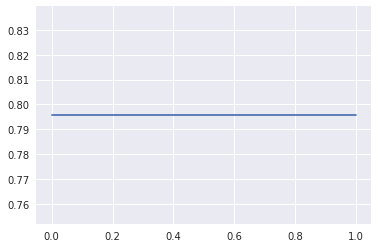

In [98]:
def main(df_oracle,df_value,df_growth, epoch=2, learning_rate=0.01):
    log = []
    
    # encode teacher action to feature
    # e.g.) [1,2,0,4,4] / len(trajectories)
    teacher_features = encoding(df_oracle,df_value,df_growth)
    print('teacher_features')
    print(teacher_features)
    #print(teacher_features.shape)
    dim = 1
    for d in teacher_features.shape:
        dim = dim * d
    theta = np.random.uniform(low=-1, high=1, size=dim)
    print('theta')
    print(theta)
    
    # e.g.) trajectories = [[12, 13, 14, 14, 15, 11, 7, 3, 3], [12, 13, 14, 15, 11, 10, 14, 15, 11, 7, 3, 3]]
    chunks, trajectories = split2trj(df_oracle)
    
    for e in tqdm(range(epoch)):
        # Estimate reward.
        rewards = theta.reshape(teacher_features.shape)

        # Estimate feature under policy. 
        # features_under_policy(df_values, df_growth, feature, rewards, chunk, trajectories):
        features = features_under_policy(df_value, df_growth, teacher_features, rewards, chunks, trajectories)

        # Update to close to teacher.
        update = teacher_features - features
        print(features)
        theta += learning_rate * update.reshape(theta.shape)
        
        log.append(np.sum(abs(update)))

    estimated = theta.reshape(teacher_features.shape)
    print(estimated)
    return estimated, log

estimated, log = main(df_oracle,df_value,df_growth)
sns.set()
plt.plot(log)

In [ ]:
def main():
    irl = MaxEntIRL(env)
    # one-hot vecの基底を作成，縦に積む．
    state_features = np.vstack([self.env.state_to_feature(s)
                               for s in self.env.states])
    theta = np.random.uniform(size=state_features.shape[1])

    # 行動をone-hotのエピソード平均へ 
    # e.g.) trajectories = [[12, 13, 14, 14, 15, 11, 7, 3, 3], [12, 13, 14, 15, 11, 10, 14, 15, 11, 7, 3, 3]]
    teacher_features = self.calculate_expected_feature(trajectories)

    for e in tqdm(range(epoch)):
        # Estimate reward.
        rewards = state_features.dot(theta.T)

        # Estimate feature under policy.
        features = self.expected_features_under_policy(
                            self.planner.policy, trajectories)

        # Update to close to teacher.
        update = teacher_features - features.dot(state_features)
        theta += learning_rate * update

    estimated = state_features.dot(theta.T)
    estimated = estimated.reshape(self.env.shape)
    
    print(rewards)
    env.plot_on_grid(rewards)

In [ ]:
teacher_feature = pd.DataFrame((df_oracle > 0).sum()/df_oracle.shape[0],columns=['p'])
teacher_feature['n'] = 1 - teacher_feature.p
teacher_feature